In [31]:
import pandas as pd
import sentence_transformers
from transformers import AutoTokenizer, AutoModel
from adapters import AutoAdapterModel
from tqdm import tqdm
from embeddingModelsList import embeddings_model_names
from sentence_transformers import SentenceTransformer

In [6]:
model_names = embeddings_model_names


['nvidia/NV-Embed-2', 'sentence-transformers/all-MiniLM-L6-v2', 'allenai/specter2_base', 'dunzhang/stella_en_1.5B_v5', 'ClimateBERT/netzero-reduction', 'ClimateBERT/distilroberta-base-climate-detectorjxm/cde-small-V2']


In [63]:
import pandas as pd
from transformers import AutoTokenizer
from adapters import AutoAdapterModel
from tqdm import tqdm

# Load the two CSV files
gold_standard_csv = "./goldStandardPapers/standards_v2_140125.csv"

gold_df = pd.read_csv(gold_standard_csv)

gold_df = gold_df[gold_df["catalysis_type"] != "unknown"]

gold_df.dropna(subset=["abstract"], inplace=True)  # Drop rows without an abstract
gold_df = gold_df[gold_df["title"].notna() | gold_df["abstract"].notna()]

# Concatenate title and abstract (if title is missing, use only the abstract)
gold_df["text"] = gold_df.apply(
    lambda row: (row["title"] + " [SEP] " if pd.notna(row["title"]) else "") + row["abstract"], axis=1
)

model_name = 'specter2'
tokenizer = AutoTokenizer.from_pretrained("allenai/specter2_base")
model = AutoAdapterModel.from_pretrained("allenai/specter2_base")

# Load and activate the Specter2 adapter
model.load_adapter("allenai/specter2", source="hf", load_as="classification", set_active=True)

# Process the input texts in batches
batch_size = 1
texts = gold_df["text"].tolist()
embeddings = []

# Process the input texts in batches with a progress bar
for i in tqdm(range(0, len(texts), batch_size), desc="Generating Embeddings", unit="batch"):
    # Prepare the batch
    batch = texts[i:i+batch_size]
    inputs = tokenizer(batch, padding=True, truncation=True,
                       return_tensors="pt", return_token_type_ids=False, max_length=512)

    # Compute embeddings
    outputs = model(**inputs)
    batch_embeddings = outputs.last_hidden_state[:, 0, :].detach().numpy()  # Take [CLS] token embeddings
    embeddings.append(batch_embeddings)

# Combine embeddings into a single array
import numpy as np
embeddings = np.vstack(embeddings)

# Save embeddings to a file for future use
np.save(f"{model_name}_embeddings.npy", embeddings)

# Save the corresponding paper metadata (e.g., OpenAlex ID) to a CSV
gold_df.reset_index(drop=True, inplace=True)
gold_df["embedding_index"] = np.arange(len(gold_df))  # Add an index for cross-referencing embeddings
gold_df.to_csv("paper_metadata_with_embeddings.csv", index=False)

print(f"Processed {len(gold_df)} papers and saved embeddings.")

Generating Embeddings: 100%|██████████| 1951/1951 [01:58<00:00, 16.50batch/s]


Processed 1951 papers and saved embeddings.


In [55]:
# --------------------------------------------------
# 4. Generate Embeddings (SciBERT example)
# --------------------------------------------------
model_name = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

texts = gold_df["text"].tolist()  # all non-null abstracts
embeddings = model.encode(texts, convert_to_numpy=True, show_progress_bar=True)

# Save embeddings to a file for future use
np.save(f"miniLM_embeddings.npy", embeddings)
print(embeddings.shape)

Batches: 100%|██████████| 61/61 [00:07<00:00,  8.12it/s]

(1951, 384)


In [69]:
# --------------------------------------------------
# 2. Load PhysBERT
# --------------------------------------------------
tokenizer = AutoTokenizer.from_pretrained("thellert/physbert_cased")
model = AutoModel.from_pretrained("thellert/physbert_cased")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --------------------------------------------------
# 3. Generate Embeddings
# --------------------------------------------------
texts = gold_df["text"].tolist()
embeddings = []

print("Generating embeddings with PhysBERT...")
for text in tqdm(texts, desc="Processing", unit="papers"):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    # Move inputs to GPU if available
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract token embeddings (ignoring [CLS] and [SEP] tokens)
    token_embeddings = outputs.last_hidden_state[:, 1:-1, :]
    
    # Mean pooling (average over tokens)
    sentence_embedding = token_embeddings.mean(dim=1)
    
    # Normalize embedding
    normalized_embedding = F.normalize(sentence_embedding, p=2, dim=1).cpu().numpy()
    
    embeddings.append(normalized_embedding)

# Convert list to NumPy array
embeddings = np.vstack(embeddings)

# --------------------------------------------------
# 4. Save Embeddings and Metadata
# --------------------------------------------------
# Save embeddings
np.save("physbert_embeddings.npy", embeddings)

# Save metadata with embedding index for cross-referencing
gold_df["embedding_index"] = np.arange(len(gold_df))  # Add an index for each embedding
gold_df.to_csv("gold_standard_with_physbert_embeddings.csv", index=False)

print(f"Generated embeddings for {len(texts)} papers. Embeddings saved to 'physbert_embeddings.npy'.")

Generating embeddings with PhysBERT...


Processing: 100%|██████████| 1951/1951 [02:02<00:00, 15.98papers/s]

Generated embeddings for 1951 papers. Embeddings saved to 'physbert_embeddings.npy'.


In [58]:
import torch.nn.functional as F

# Assuming `embeddings` is a NumPy array generated by the model
import torch
embeddings_tensor = torch.tensor(embeddings)  # Convert NumPy array to PyTorch tensor
print(embeddings)
# Apply L2 normalization along the last dimension (each embedding vector)
normalized_embeddings = F.normalize(embeddings_tensor, p=2, dim=1)

# Convert back to NumPy if needed
normalized_embeddings = normalized_embeddings.numpy()
print(normalized_embeddings)

[[-0.0558938  -0.02474387 -0.06389584 ... -0.03414059  0.10799234
  -0.1411147 ]
 [-0.04625807  0.00965723 -0.00722003 ... -0.02464803  0.04648793
  -0.12914935]
 [-0.09039396  0.02002277 -0.00160558 ... -0.05728325  0.01457496
  -0.05755286]
 ...
 [-0.02835702 -0.02065472 -0.02148949 ... -0.05978585  0.04987442
  -0.09750243]
 [ 0.01020244  0.00223734 -0.00762481 ... -0.00031131  0.01569445
   0.00807926]
 [-0.04886233 -0.06896976 -0.08283786 ... -0.06054159 -0.02115142
  -0.04697314]]
[[-0.0558938  -0.02474387 -0.06389584 ... -0.03414059  0.10799234
  -0.1411147 ]
 [-0.04625807  0.00965723 -0.00722003 ... -0.02464803  0.04648793
  -0.12914935]
 [-0.09039397  0.02002277 -0.00160558 ... -0.05728325  0.01457496
  -0.05755287]
 ...
 [-0.02835702 -0.02065472 -0.02148949 ... -0.05978585  0.04987442
  -0.09750243]
 [ 0.01020244  0.00223734 -0.00762481 ... -0.00031131  0.01569445
   0.00807926]
 [-0.04886233 -0.06896976 -0.08283786 ... -0.06054159 -0.02115142
  -0.04697314]]


In [ ]:
# --------------------------------------------------
# 2. Configure Nv-Embed-v2 Model
# --------------------------------------------------
model_name = "nvidia/NV-embed-v2"
model = SentenceTransformer(model_name, trust_remote_code=True)
model.max_seq_length = 32768  # Set maximum sequence length
model.tokenizer.padding_side = "right"  # Ensure proper tokenizer behavior

# Define a helper function to add the EOS token to each input
def add_eos(input_examples, model):
    return [input_example + model.tokenizer.eos_token for input_example in input_examples]

# --------------------------------------------------
# 3. Prepare Texts and Generate Embeddings
# --------------------------------------------------
# Extract text for embedding
texts = gold_df["text"].tolist()

# Add EOS token to the input texts
texts_with_eos = add_eos(texts, model)

# Generate embeddings
print("Generating embeddings with Nv-Embed-v2...")
embeddings = model.encode(
    texts_with_eos,
    batch_size=1,  # You can adjust this based on your hardware capabilities
    normalize_embeddings=True,  # Normalize embeddings for cosine similarity
    show_progress_bar=True
)

# --------------------------------------------------
# 4. Save Embeddings and Metadata
# --------------------------------------------------
# Save embeddings to a .npy file for future use
np.save("NV_embeddings.npy", embeddings)

# Save metadata with embedding index for cross-referencing
gold_df["embedding_index"] = np.arange(len(gold_df))  # Add an index for each embedding
gold_df.to_csv("gold_standard_with_nv_embeddings.csv", index=False)

print(f"Generated embeddings for {len(texts)} papers. Embeddings saved to 'NV_embeddings.npy'.")

Loading checkpoint shards:  25%|██▌       | 1/4 [01:52<05:37, 112.37s/it]

In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, v_measure_score
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

# --------------------------------------------------
# 1. Load Data
# --------------------------------------------------
# Load embeddings and metadata
embeddings = np.load("specter2_classification_embeddings.npy")
# embeddings = np.load("miniLM_embeddings.npy")
metadata = pd.read_csv("paper_metadata_with_embeddings.csv")

# Drop rows where 'catalysis_type' or 'application_theme' is 'unknown'
metadata = metadata[(metadata["catalysis_type"] != "unknown") & (metadata["application_theme"] != "unknown")]

# Ensure embeddings match the filtered metadata
embeddings = embeddings[metadata.index]

# Encode true labels as integers for clustering evaluation
metadata["catalysis_type_encoded"] = metadata["catalysis_type"].factorize()[0]
metadata["application_theme_encoded"] = metadata["application_theme"].factorize()[0]

# --------------------------------------------------
# 2. Define Clustering Algorithms Dynamically
# --------------------------------------------------
def get_clustering_algorithms(n_clusters):
    """
    Generate clustering algorithms with dynamic parameters based on the number of clusters.

    Parameters:
    - n_clusters (int): The number of unique clusters.

    Returns:
    - dict: A dictionary of clustering algorithms with appropriate configurations.
    """
    return {
        "K-Means": KMeans(n_clusters=n_clusters, random_state=42),
        "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
        "Agglomerative": AgglomerativeClustering(n_clusters=n_clusters),
        "GMM": GaussianMixture(n_components=n_clusters, random_state=42),
        "HDBSCAN": hdbscan.HDBSCAN(min_cluster_size=5)
    }

# --------------------------------------------------
# 3. Define Evaluation Metrics
# --------------------------------------------------
def evaluate_clustering(true_labels, predicted_labels, embeddings):
    """
    Compute clustering evaluation metrics with noise handling for DBSCAN.
    """
    valid_clusters = len(set(predicted_labels) - {-1})  # Exclude noise (-1)
    if valid_clusters < 2:
        return {
            "Silhouette": np.nan,
            "Calinski-Harabasz": np.nan,
            "Davies-Bouldin": np.nan,
            "V-Measure": np.nan
        }
    
    # Mask noise points for metrics
    mask = predicted_labels != -1
    silhouette = silhouette_score(embeddings[mask], predicted_labels[mask]) if np.any(mask) else np.nan
    calinski_harabasz = calinski_harabasz_score(embeddings[mask], predicted_labels[mask]) if np.any(mask) else np.nan
    davies_bouldin = davies_bouldin_score(embeddings[mask], predicted_labels[mask]) if np.any(mask) else np.nan
    v_measure = v_measure_score(true_labels, predicted_labels)  # V-Measure includes noise

    return {
        "Silhouette": silhouette,
        "Calinski-Harabasz": calinski_harabasz,
        "Davies-Bouldin": davies_bouldin,
        "V-Measure": v_measure
    }

# --------------------------------------------------
# 4. Run Clustering and Evaluate
# --------------------------------------------------
results = []

for target, label_column in [("catalysis_type", "catalysis_type_encoded"), ("application_theme", "application_theme_encoded")]:
    print(f"\nEvaluating clustering for {target}...")

    # Determine the number of clusters based on unique labels
    n_clusters = len(metadata[label_column].unique())
    clustering_algorithms = get_clustering_algorithms(n_clusters)

    # Run each clustering algorithm
    for name, algorithm in clustering_algorithms.items():
        print(f"Running {name} clustering for {target}...")
        
        # Fit and predict clusters
        predicted_labels = algorithm.fit_predict(embeddings)

        # Compute and store evaluation metrics
        metrics = evaluate_clustering(metadata[label_column], predicted_labels, embeddings)
        metrics["Clustering Method"] = name
        metrics["Target"] = target
        results.append(metrics)

# --------------------------------------------------
# 5. Save and Display Results
# --------------------------------------------------
results_df = pd.DataFrame(results)

# Save results to a CSV
results_df.to_csv("clustering_evaluation_results.csv", index=False)

print("\nClustering evaluation complete. Results saved to 'clustering_evaluation_results.csv'.")

# Display the results in a readable table
print(results_df)


Evaluating clustering for catalysis_type...
Running K-Means clustering for catalysis_type...
Running DBSCAN clustering for catalysis_type...
Running Agglomerative clustering for catalysis_type...
Running GMM clustering for catalysis_type...
Running HDBSCAN clustering for catalysis_type...

Evaluating clustering for application_theme...
Running K-Means clustering for application_theme...
Running DBSCAN clustering for application_theme...
Running Agglomerative clustering for application_theme...
Running GMM clustering for application_theme...
Running HDBSCAN clustering for application_theme...

Clustering evaluation complete. Results saved to 'clustering_evaluation_results.csv'.
   Silhouette  Calinski-Harabasz  Davies-Bouldin  V-Measure Clustering Method  \
0    0.116541          61.301003        2.288581   0.398978           K-Means   
1         NaN                NaN             NaN        NaN            DBSCAN   
2    0.083924          56.618053        2.272726   0.434469     Agglom

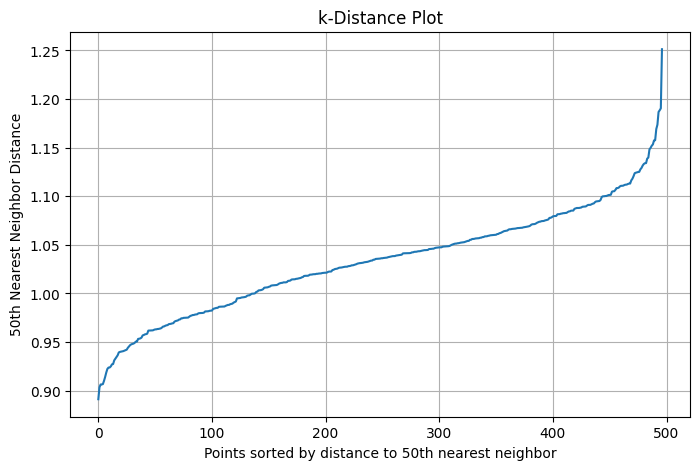

In [41]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Fit NearestNeighbors to find distances to the k-th nearest point
k = 50  # Same as min_samples
neigh = NearestNeighbors(n_neighbors=k)
distances, indices = neigh.fit(embeddings).kneighbors(embeddings)

# Sort distances to find the elbow
sorted_distances = np.sort(distances[:, k - 1])
plt.figure(figsize=(8, 5))
plt.plot(sorted_distances)
plt.title("k-Distance Plot")
plt.xlabel("Points sorted by distance to {}th nearest neighbor".format(k))
plt.ylabel("{}th Nearest Neighbor Distance".format(k))
plt.grid()
plt.show()

In [68]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import hdbscan

# --------------------------------------------------
# 1. Load Data
# --------------------------------------------------
# Load embeddings and metadata
embeddings = np.load("miniLM_embeddings.npy")
metadata = pd.read_csv("paper_metadata_with_embeddings.csv")

# Drop unknowns
metadata = metadata[(metadata["catalysis_type"] != "unknown") & (metadata["application_theme"] != "unknown")]

# Ensure embeddings match metadata
embeddings = embeddings[metadata.index]

# Encode categorical labels
metadata["catalysis_type_encoded"] = metadata["catalysis_type"].factorize()[0]
metadata["application_theme_encoded"] = metadata["application_theme"].factorize()[0]

# Compute Cosine Similarity Matrix
cos_sim_matrix = cosine_similarity(embeddings)

# --------------------------------------------------
# 2. Compute Cosine Similarity Scores
# --------------------------------------------------
def compute_cosine_cluster_similarity(cluster_labels):
    """
    Computes average cosine similarity for:
    - Within each cluster (higher = better clustering)
    - Between different clusters (lower = better separation)
    """
    unique_clusters = np.unique(cluster_labels)
    within_sim = []
    between_sim = []

    for c in unique_clusters:
        if c == -1:  # Ignore noise in DBSCAN
            continue
        
        cluster_indices = np.where(cluster_labels == c)[0]
        non_cluster_indices = np.where(cluster_labels != c)[0]

        if len(cluster_indices) > 1:  # Avoid errors with single-member clusters
            cluster_sim = cos_sim_matrix[np.ix_(cluster_indices, cluster_indices)]
            within_sim.append(np.mean(cluster_sim))  # Avg similarity within the cluster

        # Compare to all other clusters
        if len(cluster_indices) > 0 and len(non_cluster_indices) > 0:
            between_sim.append(np.mean(cos_sim_matrix[np.ix_(cluster_indices, non_cluster_indices)]))

    return np.mean(within_sim), np.mean(between_sim)

# --------------------------------------------------
# 3. Run Clustering and Evaluate
# --------------------------------------------------
results = []

for target, label_column in [("catalysis_type", "catalysis_type_encoded"), ("application_theme", "application_theme_encoded")]:
    print(f"\nEvaluating clustering for {target}...")

    # Determine number of clusters
    n_clusters = len(metadata[label_column].unique())

    # Clustering algorithms
    clustering_algorithms = {
        "K-Means": KMeans(n_clusters=n_clusters, random_state=42),
        "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
        "Agglomerative": AgglomerativeClustering(n_clusters=n_clusters),
        "GMM": GaussianMixture(n_components=n_clusters, random_state=42),
        "HDBSCAN": hdbscan.HDBSCAN(min_cluster_size=10)
    }

    # Run each clustering algorithm
    for name, algorithm in clustering_algorithms.items():
        print(f"Running {name} clustering for {target}...")
        
        # Fit and predict clusters
        predicted_labels = algorithm.fit_predict(embeddings)

        # Compute average cosine similarity
        within_cluster_sim, between_cluster_sim = compute_cosine_cluster_similarity(predicted_labels)

        # Store results
        results.append({
            "Clustering Method": name,
            "Target": target,
            "Within-Cluster Cosine Similarity": within_cluster_sim,
            "Between-Cluster Cosine Similarity": between_cluster_sim
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save results to CSV
results_df.to_csv("clustering_cosine_evaluation_results.csv", index=False)

# Display the results in a structured table
print(results_df)


Evaluating clustering for catalysis_type...
Running K-Means clustering for catalysis_type...
Running DBSCAN clustering for catalysis_type...
Running Agglomerative clustering for catalysis_type...
Running GMM clustering for catalysis_type...
Running HDBSCAN clustering for catalysis_type...

Evaluating clustering for application_theme...
Running K-Means clustering for application_theme...
Running DBSCAN clustering for application_theme...
Running Agglomerative clustering for application_theme...
Running GMM clustering for application_theme...
Running HDBSCAN clustering for application_theme...
  Clustering Method             Target  Within-Cluster Cosine Similarity  \
0           K-Means     catalysis_type                          0.442518   
1            DBSCAN     catalysis_type                               NaN   
2     Agglomerative     catalysis_type                          0.452686   
3               GMM     catalysis_type                          0.442518   
4           HDBSCAN 

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
from tqdm import tqdm

# --------------------------------------------------
# 1. Load Data
# --------------------------------------------------
# Replace with your embeddings and metadata file paths
embeddings = np.load("physbert_embeddings.npy")  # Embeddings as a NumPy array
metadata = pd.read_csv("gold_standard_with_physbert_embeddings.csv")

# Target column for evaluation (e.g., "catalysis_type")
target_column = "catalysis_type"
metadata = metadata[metadata[target_column] != "unknown"]  # Exclude "unknown" classes

# Encode target labels
metadata["target_encoded"] = metadata[target_column].factorize()[0]
y = metadata["target_encoded"].values

# --------------------------------------------------
# 2. Stratified 10-Fold Cross-Validation
# --------------------------------------------------
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
v_measure_scores = []

for train_index, test_index in tqdm(skf.split(embeddings, y), desc="Cross-Validation", unit="fold"):
    # Split data into training and test sets
    X_train, X_test = embeddings[train_index], embeddings[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Standardize the training and test sets
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Fit KMeans on the training set
    n_clusters = len(np.unique(y_train))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_train)
    
    # Predict cluster labels on the test set
    y_pred = kmeans.predict(X_test)
    
    # Compute V-measure score
    score = v_measure_score(y_test, y_pred)
    v_measure_scores.append(score)

# --------------------------------------------------
# 3. Compute Final Metric
# --------------------------------------------------
mean_v_measure = np.mean(v_measure_scores)
std_v_measure = np.std(v_measure_scores)
print(v_measure_scores)
# Display results
print(f"Mean V-Measure Score: {mean_v_measure:.4f}")
print(f"Standard Deviation of V-Measure: {std_v_measure:.4f}")

Cross-Validation: 10fold [00:10,  1.03s/fold]

[np.float64(0.30106220639135645), np.float64(0.345470280726316), np.float64(0.33038461699421684), np.float64(0.33377292735094166), np.float64(0.3652345572432418), np.float64(0.3912383214981262), np.float64(0.3142665385933167), np.float64(0.3331011485665065), np.float64(0.3008369970945891), np.float64(0.36639923165689003)]
Mean V-Measure Score: 0.3382
Standard Deviation of V-Measure: 0.0280



Evaluating Specter2...


Specter2 CV: 100%|██████████| 10/10 [00:11<00:00,  1.20s/fold]



Evaluating Specter2-Classification...


Specter2-Classification CV: 100%|██████████| 10/10 [00:11<00:00,  1.12s/fold]



Evaluating MiniLM...


MiniLM CV: 100%|██████████| 10/10 [00:05<00:00,  1.68fold/s]



Evaluating PhysBERT...


PhysBERT CV: 100%|██████████| 10/10 [00:09<00:00,  1.08fold/s]


ValueError: 'yerr' (shape: (4,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (1,))

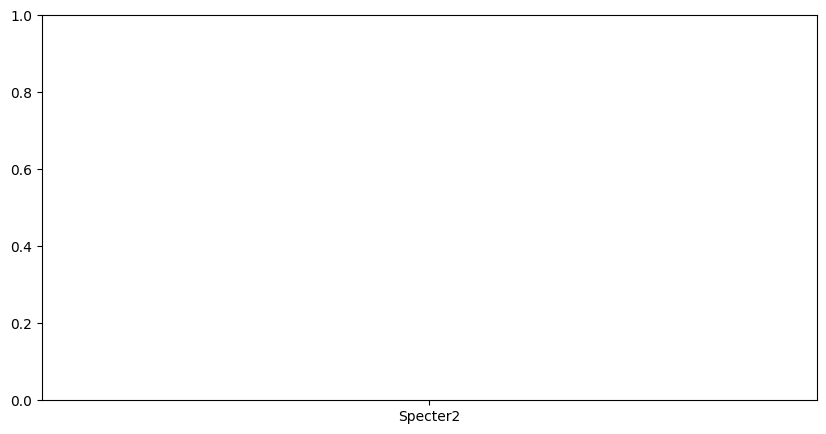

In [8]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

# --------------------------------------------------
# 1. Load Data
# --------------------------------------------------
# Load different embedding sets
embedding_files = {
    "Specter2": "specter2_embeddings.npy",
    "Specter2-Classification": "specter2_classification_embeddings.npy",
    "MiniLM": "miniLM_embeddings.npy",
    "PhysBERT": "physbert_embeddings.npy"
}

# Load metadata
metadata_file = "gold_standard_with_physbert_embeddings.csv"  # Assuming same metadata for all
metadata = pd.read_csv(metadata_file)

# Target column for evaluation (e.g., "catalysis_type")
target_column = "catalysis_type"
metadata = metadata[metadata[target_column] != "unknown"]  # Exclude "unknown" categories
metadata["target_encoded"] = metadata[target_column].factorize()[0]
y = metadata["target_encoded"].values

# --------------------------------------------------
# 2. Perform Stratified 10-Fold Cross-Validation for Each Embedding
# --------------------------------------------------
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

results = []

for model_name, embedding_path in embedding_files.items():
    print(f"\nEvaluating {model_name}...")
    
    # Load embeddings
    embeddings = np.load(embedding_path)
    
    # Ensure embeddings match metadata
    embeddings = embeddings[metadata.index]

    v_measure_scores = []
    
    for train_index, test_index in tqdm(skf.split(embeddings, y), desc=f"{model_name} CV", unit="fold", total=n_splits):
        # Split data into training and test sets
        X_train, X_test = embeddings[train_index], embeddings[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Standardize the training and test sets
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Fit KMeans on the training set
        n_clusters = len(np.unique(y_train))
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        kmeans.fit(X_train)
        
        # Predict cluster labels on the test set
        y_pred = kmeans.predict(X_test)
        
        # Compute V-measure score
        score = v_measure_score(y_test, y_pred)
        v_measure_scores.append(score)

    # Compute mean and std V-measure
    mean_v = np.mean(v_measure_scores)
    std_v = np.std(v_measure_scores)

    results.append({
        "Model": model_name,
        "Mean V-Measure": mean_v,
        "Std V-Measure": std_v
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# --------------------------------------------------
# 3. Visualize Results (Bar Chart)
# --------------------------------------------------
plt.figure(figsize=(10, 5))

# Ensure standard deviation is properly shaped
yerr_values = results_df["Std V-Measure"].values
if len(yerr_values) == 1:
    yerr_values = None  # Avoid passing incorrect shape

sns.barplot(x="Model", y="Mean V-Measure", data=results_df, palette="coolwarm", yerr=yerr_values)
plt.title("Comparison of Clustering Performance Across Embeddings")
plt.xlabel("Embedding Model")
plt.ylabel("Mean V-Measure Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# --------------------------------------------------
# 4. Visualize Embeddings with UMAP
# --------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (model_name, embedding_path) in enumerate(embedding_files.items()):
    # Load embeddings
    embeddings = np.load(embedding_path)
    
    # Reduce to 2D with UMAP
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    embeddings_2d = reducer.fit_transform(embeddings)
    
    # Scatter plot
    scatter = axes[i].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=metadata["target_encoded"], cmap="tab10", alpha=0.7)
    axes[i].set_title(f"UMAP Projection: {model_name}")
    axes[i].set_xlabel("UMAP-1")
    axes[i].set_ylabel("UMAP-2")

plt.tight_layout()
plt.show()

# Display table of results
import tabulate
print(tabulate.tabulate(results_df, headers="keys", tablefmt="grid"))
